# Stable-Diffusion-xl-base-1.0
O SDXL consiste em um conjunto de pipelines de especialistas para difusão altente: em uma primeira etapa, o modelo base é usado para gerar latentes (ruidosos), que são posteriormente processados com um modelo de refinamento especializados para as etapas finais de remoção de ruído.

### OBS: o sistema com refinador excede a memória da GPU da conta gratuita

fonte:

# Instalando os pacotes

In [1]:
!pip install diffusers --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.7 MB/s eta 0:00:00


In [2]:
!pip install invisible_watermark transformers accelerate safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.3 MB/s eta 0:00:00


# Utilizando apenas o modelo base (ruidoso)

In [3]:
from diffusers import DiffusionPipeline
import torch

In [4]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")

pipe.to("cuda")

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.19.3",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "force_zeros_for_empty_prompt": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [5]:
prompt = "Design a science research poster template that effectively communicates the key aspects of a scienctific study using a limited color palette (no more than 3-4 colors)."

In [6]:
images=pipe(prompt=prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

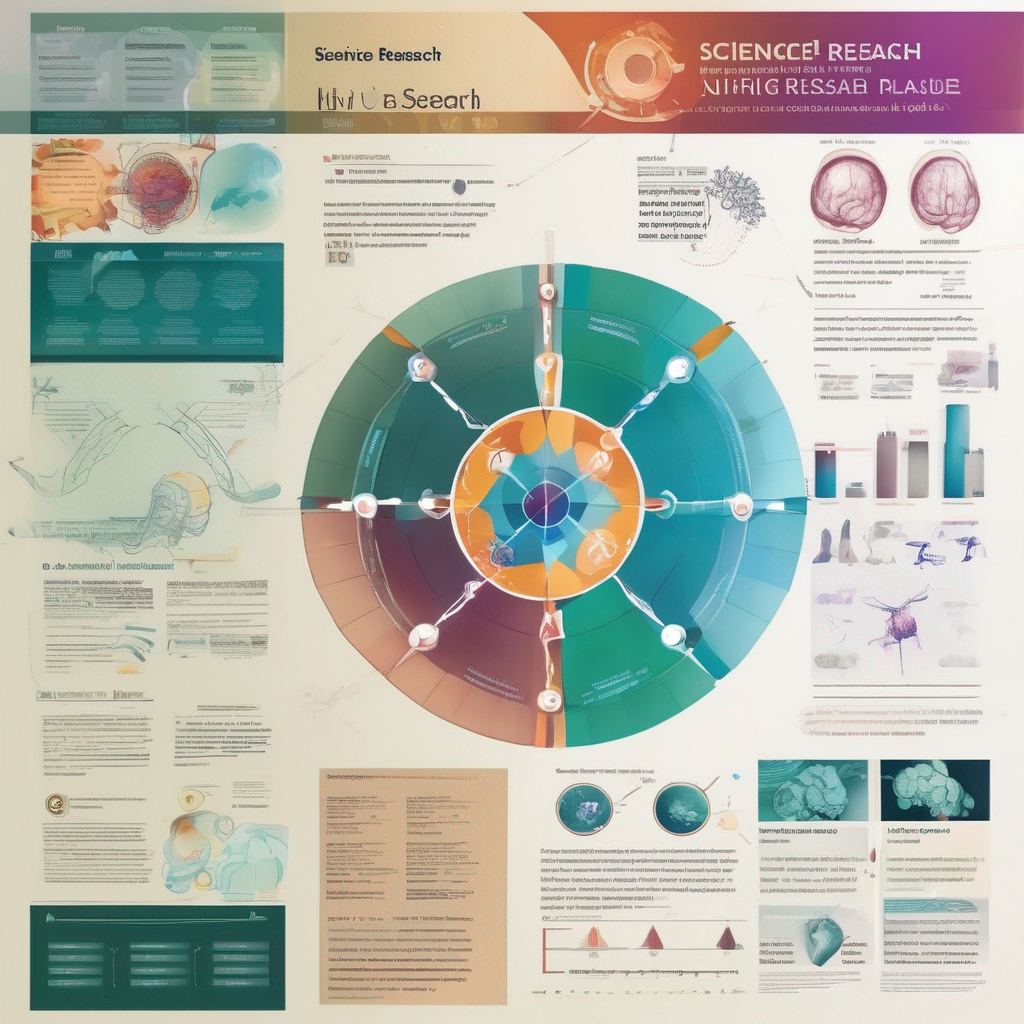

In [7]:
images

# Utilizando a base e o refinador

In [4]:
# carregando a base e o refinador
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
base.to("cuda")
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

# Defina quantas etapas e qual % de etapas a serem executadas em cada especialista (80/20) aqui
n_steps = 40
high_noise_frac = 0.8

prompt = "A majestic lion jumping from a big stone at night"

# executar ambos os especialistas
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

RuntimeError: ignored

In [ ]:
image